In [1]:
%run imports.py

Succesfully imported libraries and modules



We want to correlate spectral power and PAC intensity for a given frequency range.

Spectral power can be calculated 2 ways:
1) Sliding window over frequency and averaging spectral power (I suggest window size equal to 1.5 * bandwidth of PAC estimation filter for phase-giving oscillation)
2) FOOOF 1/f removal and estimation of power of whitened spectrum and/or sliding window spectral power mean

PAC intensity could be calculated as following:
* We don't consider y-axis frequencies below 150 Hz (N:M coupling occurs mostly below that point)
* Average or max-value (or any matrix norm essentially) of **significant** PAC in every column corresponding to the phase-giving frequency



In [2]:
def copy_patient(patient: Patient):
    new_patient = Patient(patient.name, patient.root_dir)
    for attr in patient.__dict__.keys():
        new_patient.__dict__[attr] = patient.__dict__[attr]
    return new_patient

In [3]:
def load_patients(who='all', n_total=6):
    """
    who: either all or list of patient numbers
    Returns: list of patient instances
    """
    
    with open("path_data.txt") as f:
        data_dir = f.readline()
        print(f"Reading patients in directory {data_dir}")
        
    p_list = []
        
    if who == 'all':
        iterable = range(1, n_total + 1)    
    else:
        iterable = who
        
    for i in iterable:
        print(f"Reading Patient{i}")
        p_dir = os.path.join(data_dir, f"Patient{i}")
        p_pickle_filepath = os.path.join(p_dir, f"Patient{i}.pkl")
        p = load_patient_from_pickle(p_pickle_filepath)
        p = copy_patient(p)
        p.root_dir = p_dir
        p.load_all_pacs(verbose=False)
        p_list.append(p)
        
    print("Done, returning list of patients")
    return p_list

## Patient 1: Beta - PAC correlation

In [3]:
patient = load_patient(1)

Patient directory:  D:\LAB\AlexPAC\data\Patient1


In [4]:
# example PAC and lfp spectrum

condition = "5Day OFF Rest 180sec"
placement = "R2B-3B"

pac = patient.pac[condition][placement][placement]
lfp = patient.lfp[condition][placement]

print(pac.beta_params)

(5, 48, 1, 2)


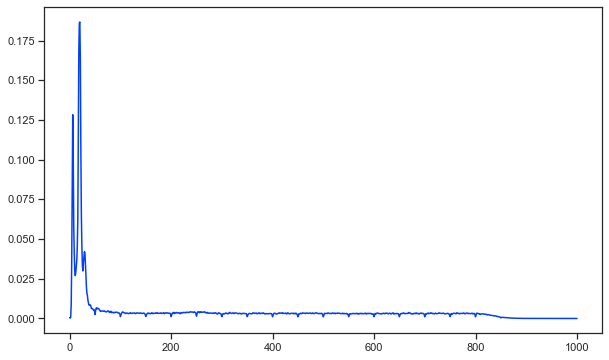

In [5]:
plt.plot(*lfp.get_psd())

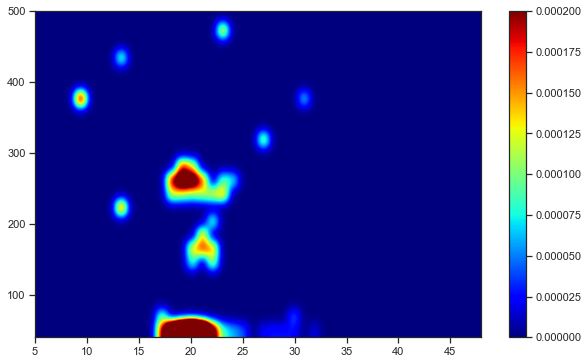

In [6]:
comodulogram(pac.pac_matrix, pac.beta_params, pac.hfo_params, pac.pvalues, significant=True, vmax=0.0002)
plt.colorbar()

#### LFP spectral power

In [19]:
f1, f2 = 4, 36 # beta freqs of interest (we really want from 5 to 35 but that's another story )

f, psd = lfp.get_psd()
mask = (f >= f1) & (f <= f2)

kernel = np.ones(3)/3
psd_average_power = np.convolve(psd[mask], kernel, mode='valid')
# Получили скользящее среднее, при этом первая точка отвечает за 5, а последняя - за 35 - отлично! 31 точка всего

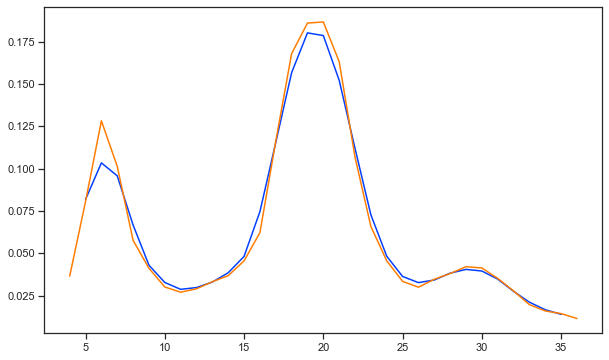

In [24]:
plt.plot(np.arange(5, 36), psd_average_power)
plt.plot(f[mask], psd[mask])

#### PAC power

In [9]:
zero_indices = (pac.pvalues > 0.01)
pac_matrix = pac.pac_matrix.copy()
pac_matrix[zero_indices] = 0

# average pac power above 160Hz is [6:, :].mean(axis=0)
# for beta it is 5 to 35

pac_power_mean = pac_matrix[6:, :31].mean(axis=0)
pac_power_max = pac_matrix[6:, :31].max(axis=0)
pac_power_mean.shape

(31,)

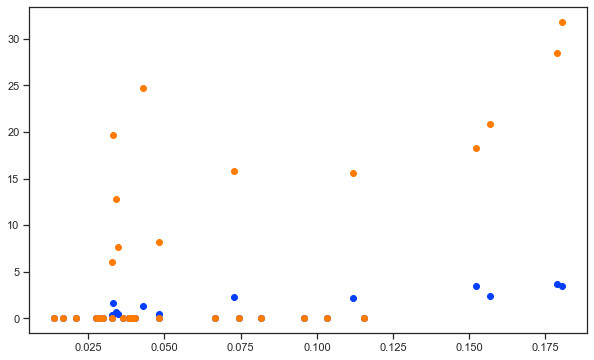

In [10]:
plt.scatter(psd_average_power, pac_power_mean * 1e+5)
plt.scatter(psd_average_power, pac_power_max * 1e+5)

In [11]:
np.corrcoef(psd_average_power, pac_power_max)

array([[1.        , 0.62428048],
       [0.62428048, 1.        ]])

In [12]:
spectral_power = np.array([])
pac_max_power = np.array([])
pac_mean_power = np.array([])

for condition in patient.conditions:
    if '180sec' in condition:
        for placement in patient.placements:
            lfp = patient.lfp[condition][placement]
            pac = patient.pac[condition][placement][placement]
            
            # spectral power
            f1, f2 = 4, 36
            f, psd = lfp.get_psd()
            mask = (f >= f1) & (f <= f2)

            kernel = np.ones(3)/3
            psd_average_power = np.convolve(psd[mask], kernel, mode='valid')
            
            # pac power
            zero_indices = (pac.pvalues > 0.01)
            pac_matrix = pac.pac_matrix.copy()
            pac_matrix[zero_indices] = 0

            pac_mean = pac_matrix[6:, :31].mean(axis=0)
            pac_max = pac_matrix[6:, :31].max(axis=0)
            
            spectral_power = np.concatenate((spectral_power, psd_average_power))
            pac_max_power = np.concatenate((pac_max_power, pac_max))
            pac_mean_power = np.concatenate((pac_mean_power, pac_mean))

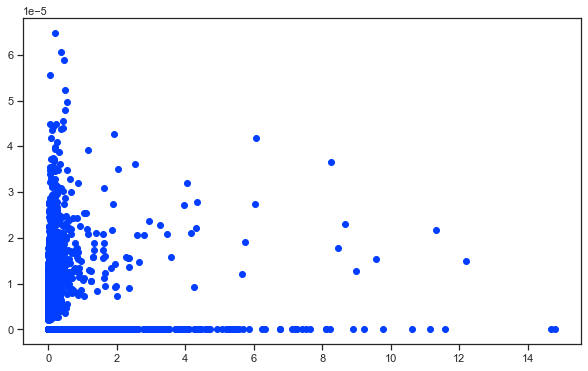

In [13]:
plt.scatter(spectral_power, pac_mean_power)

In [14]:
print(np.corrcoef(spectral_power, pac_mean_power))

print(np.corrcoef(spectral_power, pac_max_power))

[[1.         0.09880446]
 [0.09880446 1.        ]]
[[1.         0.12266818]
 [0.12266818 1.        ]]


Fixing Patient3 with copying its attributes

In [15]:
with open("path_data.txt") as f:
    data_dir = f.readline()
p3_dir = os.path.join(data_dir, "Patient3")
print("Patient directory: ", p3_dir)
p3_pickle_filepath = os.path.join(p3_dir, "Patient3.pkl")
p3 = load_patient_from_pickle(p3_pickle_filepath)
p3.root_dir = p3_dir

p3 = copy_patient(p3)

p3.load_all_pacs(verbose=False)
p3.save()

Patient directory:  D:\LAB\AlexPAC\data\Patient3
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)
Saving Patient3 object to D:\LAB\AlexPAC\data\Patient3\Patient3.pkl ...
Pickling Patient3 without ['pac']
Done, 3.1399266719818115 sec
File size: 3449.7953786849976 MB
Returning filepath for saved file


'D:\\LAB\\AlexPAC\\data\\Patient3\\Patient3.pkl'

#### Trying FOOOF method

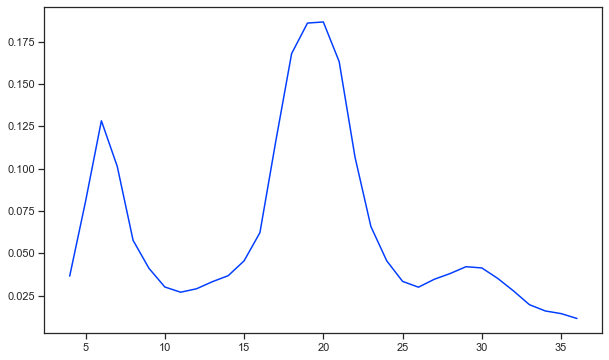


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



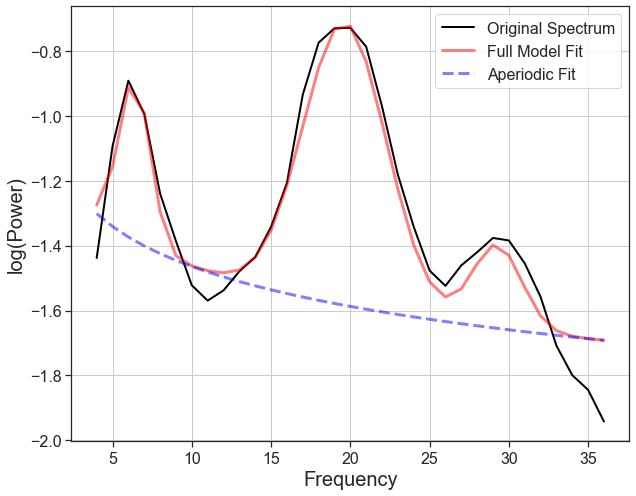

In [32]:
from fooof import FOOOF

f1, f2 = 4, 36 # beta freqs of interest (we really want from 5 to 35 but that's another story )

f, psd = lfp.get_psd()
mask = (f >= f1) & (f <= f2)

plt.plot(f[mask], psd[mask])
plt.show()

fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=3, peak_threshold=1)

fm.fit(f[mask], psd[mask])

fm.plot()
# Получили скользящее среднее, при этом первая точка отвечает за 5, а последняя - за 35 - отлично! 31 точка всего

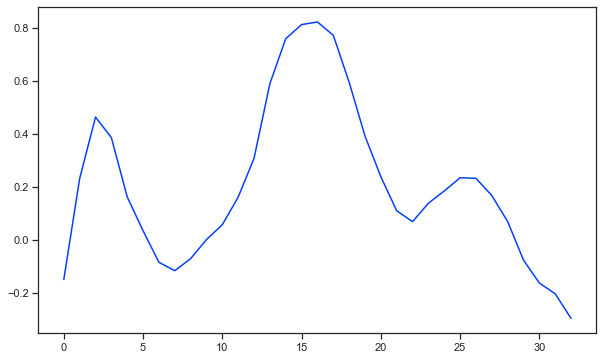

In [42]:
init_flat_spec = fm.power_spectrum - init_ap_fit


plt.plot(init_flat_spec)

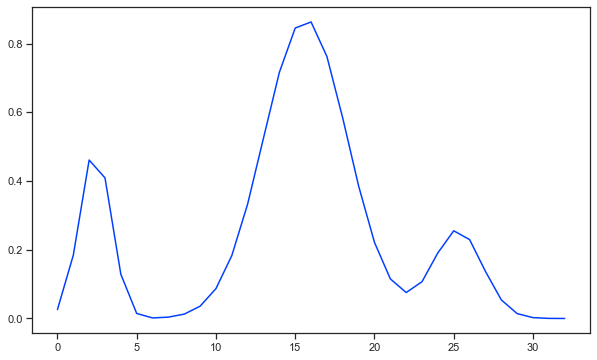

In [44]:
plt.plot(fm._peak_fit)

In [45]:
fm._peak_fit.shape

(33,)

In [47]:
f[mask].shape

(33,)

## Main correlation function

In [8]:
def get_spectral_pac_correlation(patient, 
                                 freqs=(5, 36), 
                                 spectral_power='fooof', 
                                 pac_power='max', 
                                 convolve=False, 
                                 ignore_pac_zeros=False):
    """
    Return arrays of spectral and pac powers (parametrized by similar freq range)
    Spectral power: 'psd' or 'fooof'
    PAC power: 'max', 'mean' or 'mean_squared'
    """
    spectral_power_values = np.array([])
    pac_power_values = np.array([])
    
    F0, F1 = 4, 48

    for condition in patient.conditions:
        if '180sec' in condition:
            for placement in patient.placements:
                lfp = patient.lfp[condition][placement]
                pac = patient.pac[condition][placement][placement]
                
                if not pac_exists(patient, condition, placement, placement):
                    continue
                
                """ SPECTRAL POWER """
                f, psd = lfp.get_psd() 
                lf_mask = (f >= F0 - 1) & (f <= F1 + 1)   
                psd_to_convolve = psd[lf_mask]

                # using fooof to flatten the spectrum (adjusting for 1/f)
                if spectral_power == 'fooof':
                    fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=4, peak_threshold=1, verbose=False)
                    fm.fit(f[lf_mask], psd[lf_mask])
                    psd_to_convolve = fm._peak_fit
                    
                # sliding average to adjust for PAC filter bandwidth
                if convolve:
                    kernel = np.ones(3)/3
                    psd_conv = np.convolve(psd_to_convolve, kernel, mode='valid') 
                else:
                    psd_conv = psd_to_convolve[1:-1] # cut first and last for same result as convolution
                
                conv_mask = (f >= F0) & (f <= F1)
                f_conv = f[conv_mask]
                
                f0, f1 = freqs
                final_mask = (f_conv >= f0) & (f_conv <= f1)
                
                current_spectral_power = psd_conv[final_mask] # should be the length of range(f0, f1 + 1)
                
                """ PAC POWER """
                # converting pac_matrix to a significant one
                zero_indices = (pac.pvalues > 0.01)
                pac_matrix = pac.pac_matrix.copy()
                pac_matrix[zero_indices] = 0
                
                idx1 = np.argmin(np.abs(pac.beta_freqs - freqs[0]))
                idx2 = np.argmin(np.abs(pac.beta_freqs - freqs[1])) + 1
                
                if pac_power == 'max':
                    current_pac_power = pac_matrix[6:, idx1:idx2].max(axis=0)
                    
                if pac_power == 'mean':
                    current_pac_power = pac_matrix[6:, idx1:idx2].mean(axis=0)
                    
                if pac_power == 'mean_squared':
                    current_pac_power = np.sqrt(np.sum(pac_matrix[6:, idx1:idx2] ** 2, axis=0))
                    
                assert current_pac_power.shape == current_spectral_power.shape, "PAC power and spectral power shapes do not coincide"
                    
                spectral_power_values = np.concatenate((spectral_power_values, current_spectral_power))
                pac_power_values = np.concatenate((pac_power_values, current_pac_power))
                
    if ignore_pac_zeros:
        mask = pac_power_values > 0
    else:
        mask = np.ones(len(pac_power_values), dtype='bool')
                
    return spectral_power_values[mask], pac_power_values[mask]


def plot_correlation_results(spectral_power, pac_power, **plt_params):
    plt.figure(figsize=(6, 6))
    plt.title("Correlation between spectral power and PAC power \n parametrized by phase-giving frequency ")
    plt.scatter(spectral_power, pac_power, alpha=0.8)
    plt.xlabel("Spectral Power")
    plt.ylabel("PAC power")
    plt.show()
    print(f"Pearson correlation coefficient: ", np.corrcoef(spectral_power, pac_power)[0, 1].round(2))

In [7]:
(np.arange(5) > 1).dtype

dtype('bool')

Patient directory:  D:\LAB\AlexPAC\data\Patient1
Patient 1


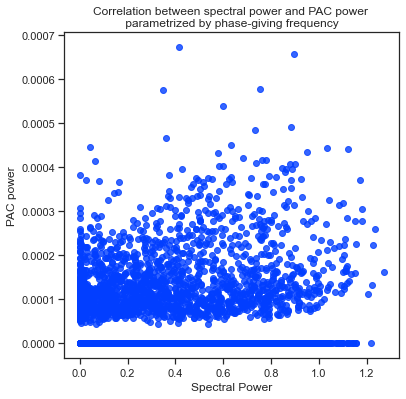

Pearson correlation coefficient:  0.19
Wall time: 38.8 s


In [11]:
%%time

p1 = load_patient(1)

print("Patient 1")
spectral_power, pac_power = get_spectral_pac_correlation(p1, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

Trying ignoring those points where PAC power is zero

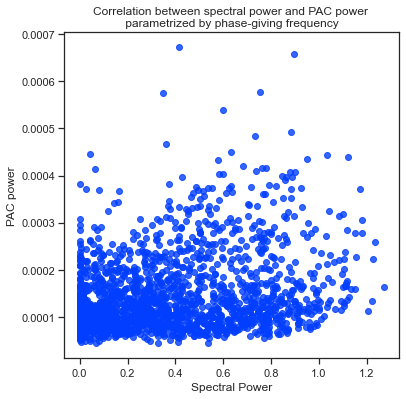

Pearson correlation coefficient:  0.3
Wall time: 33.5 s


In [12]:
%%time

spectral_power, pac_power = get_spectral_pac_correlation(p1, freqs=(6, 30), ignore_pac_zeros=True)
plot_correlation_results(spectral_power, pac_power)

In [10]:
p2 = load_patient(2)

Patient directory:  D:\LAB\AlexPAC\data\Patient2


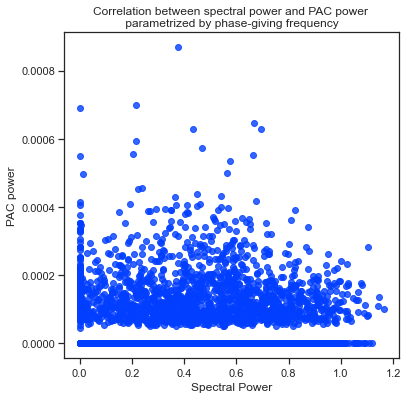

Pearson correlation coefficient:  0.15
Wall time: 16.9 s


In [74]:
%%time

print("Patient 2")
spectral_power, pac_power = get_spectral_pac_correlation(p2, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

In [77]:
with open("path_data.txt") as f:
    data_dir = f.readline()

p3_dir = os.path.join(data_dir, "Patient3")
print("Patient directory: ", p3_dir)
p3_pickle_filepath = os.path.join(p3_dir, "Patient3.pkl")

p3 = load_patient_from_pickle(p3_pickle_filepath)

p3.root_dir = p3_dir

p3 = copy_patient(p3)
p3.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient3
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)


Patient 3


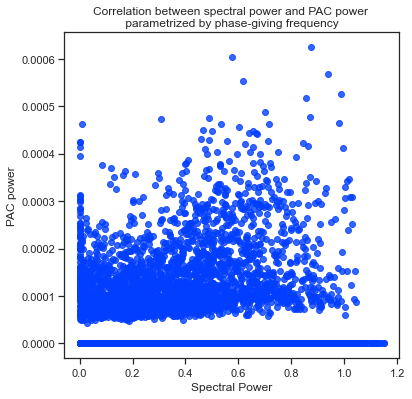

Pearson correlation coefficient:  0.15
Wall time: 22.6 s


In [81]:
%%time

print("Patient 3")
spectral_power, pac_power = get_spectral_pac_correlation(p3, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

In [83]:
with open("path_data.txt") as f:
    data_dir = f.readline()

p4_dir = os.path.join(data_dir, "Patient4")
print("Patient directory: ", p4_dir)
p4_pickle_filepath = os.path.join(p4_dir, "Patient4.pkl")

p4 = load_patient_from_pickle(p4_pickle_filepath)

p4.root_dir = p4_dir

p4 = copy_patient(p4)
p4.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient4
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)


Patient 4


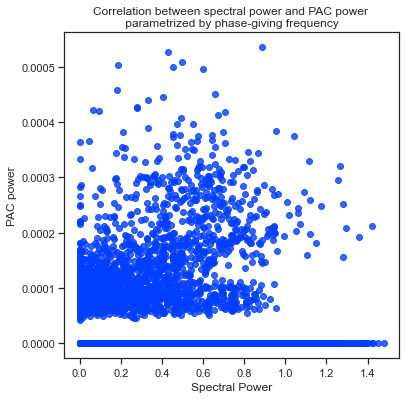

Pearson correlation coefficient:  0.11
Wall time: 25.1 s


In [84]:
%%time

print("Patient 4")
spectral_power, pac_power = get_spectral_pac_correlation(p4, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

Patient directory:  D:\LAB\AlexPAC\data\Patient5
Patient 5


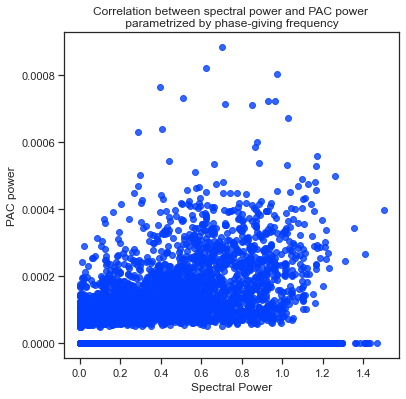

Pearson correlation coefficient:  0.23
Wall time: 25.3 s


In [85]:
%%time

p5 = load_patient(5)
print("Patient 5")
spectral_power, pac_power = get_spectral_pac_correlation(p5, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

Patient directory:  D:\LAB\AlexPAC\data\Patient6
Patient 6


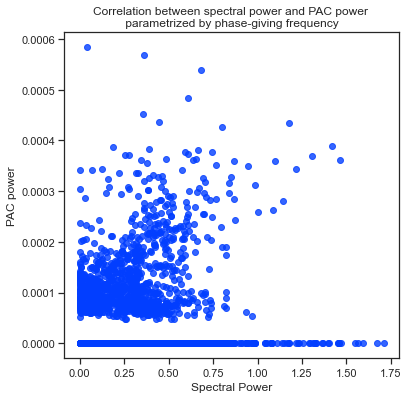

Pearson correlation coefficient:  0.11
Wall time: 15.4 s


In [87]:
%%time

p6 = load_patient(6)
print("Patient 6")
spectral_power, pac_power = get_spectral_pac_correlation(p6, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

### Comparison between different power calculation methods


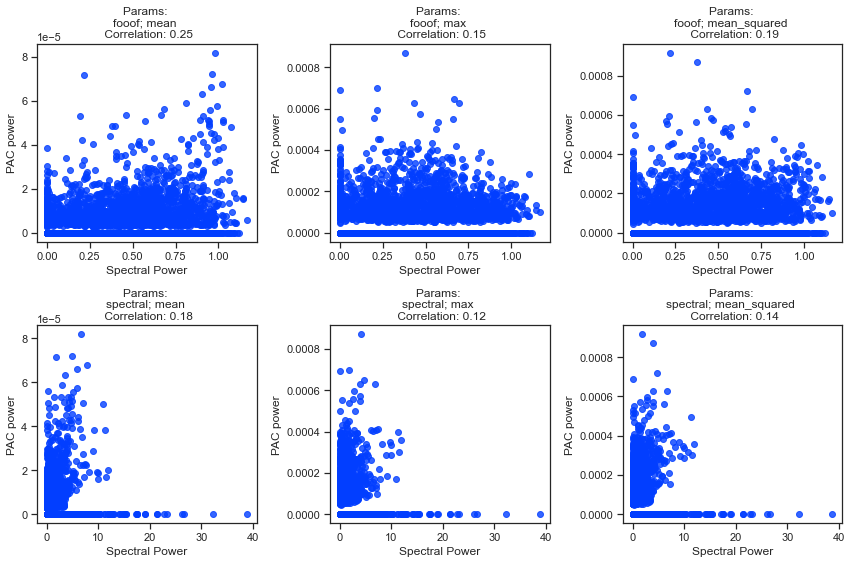

In [12]:
spectral_params = ['fooof', 'spectral']
pac_params = ['mean', 'max', 'mean_squared']

fig, axes = plt.subplots(len(spectral_params), len(pac_params), figsize=(12, 8))

for i, spectral_param in enumerate(spectral_params):
    for j, pac_param in enumerate(pac_params):
        ax = axes[i, j]
        spectral_power, pac_power = get_spectral_pac_correlation(p2, (6, 30), spectral_param, pac_param)
        corr_coef = np.corrcoef(spectral_power, pac_power)[0, 1].round(2)
        
        ax.set_title(f"Params: \n{spectral_param}; {pac_param} \n Correlation: {corr_coef}")
        ax.scatter(spectral_power, pac_power, alpha=0.8)
        ax.set_xlabel("Spectral Power")
        ax.set_ylabel("PAC power")
              
plt.tight_layout()
plt.show()

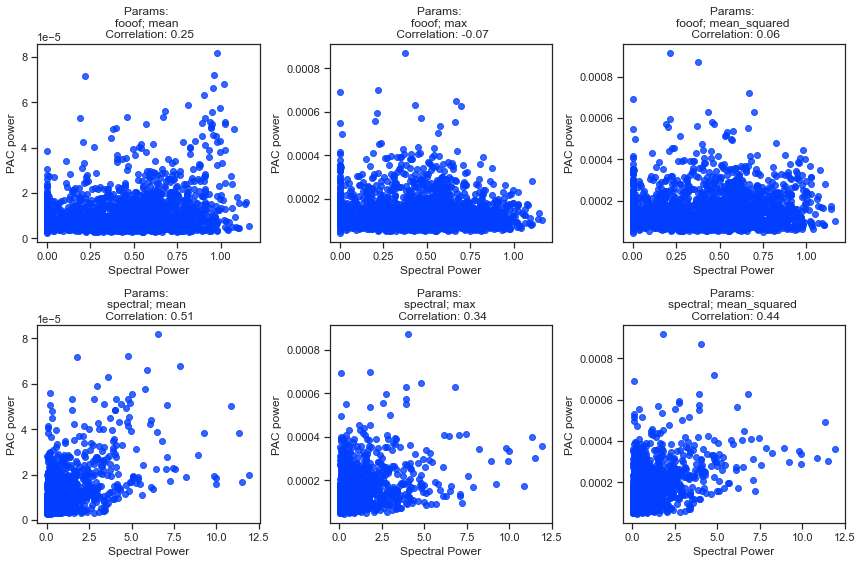

In [11]:
spectral_params = ['fooof', 'spectral']
pac_params = ['mean', 'max', 'mean_squared']

fig, axes = plt.subplots(len(spectral_params), len(pac_params), figsize=(12, 8))

for i, spectral_param in enumerate(spectral_params):
    for j, pac_param in enumerate(pac_params):
        ax = axes[i, j]
        spectral_power, pac_power = get_spectral_pac_correlation(p2, (6, 30), spectral_param, pac_param, ignore_pac_zeros=True)
        corr_coef = np.corrcoef(spectral_power, pac_power)[0, 1].round(2)
        
        ax.set_title(f"Params: \n{spectral_param}; {pac_param} \n Correlation: {corr_coef}")
        ax.scatter(spectral_power, pac_power, alpha=0.8)
        ax.set_xlabel("Spectral Power")
        ax.set_ylabel("PAC power")
              
plt.tight_layout()
plt.show()

## Functions for HFO and Beta power estimation from Cross-PAC bipartate graph coloring

#### Funcs for beta/HFO power

In [2]:
def get_power(y, power_type='p', p=2):
    """
    max, mean, p, std
    """
    if power_type == 'max':
        return np.max(y)
    if power_type == 'mean':
        return np.mean(y)
    if power_type == 'p':
        return np.mean(y ** p) ** (1/p)
    if power_type == 'std':
        return np.std(y ** p) ** (1/p)
    

In [22]:
def get_beta_power(lfp: LFP, freqs=(14, 35), power_type='max', p=2):

    # dividing by std
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)
    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)
    
    # getting PSD between 2 to 50 Hz
    f, psd = lfp_norm.get_psd()
    
    mask1= (f >= 2) & (f < 50)

    # getting FOOOF peak fit (without aperiodic component)
    fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=4, peak_threshold=1, verbose=False)
    fm.fit(f[mask1], psd[mask1])
    y_hat = fm._peak_fit

    # applying only to desired freq range (10 - 35) by default
    f0, f1 = freqs
    final_mask = (f[mask1] >= f0) & (f[mask1] <= f1)
    
    n_peaks = fm.peak_params_.shape[0]
    peak_freqs = fm.peak_params_[:, 0]
    peak_heights = fm.peak_params_[:, 1]

    #beta_power = np.max(peak_heights[(peak_freqs >= freqs[0]) & (peak_freqs <= freqs[1])])
    if n_peaks == 0:
        return 0 
    peak_powers = np.zeros(n_peaks)
    for i in range(n_peaks):
        peak_freq = fm.peak_params_[i, 0]
        if (peak_freq >= freqs[0]) and (peak_freq <= freqs[1]):
            peak_powers[i] = fm.peak_params_[i, 1]   
    return np.max(peak_powers)

In [23]:
patient = p2
condition = "1Day OFF Rest 180sec"
placement1 = "L1-2B"
placement2 = "L2B-3B"

placements = ["L1-2B", "L2B-3B"]

freqs = (14, 35)
lfp = p2.lfp[condition][placement2]

lfp_data = lfp.data.copy()
lfp_data = lfp_data / np.std(lfp_data)
lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)

# getting PSD between 2 to 50 Hz
f, psd = lfp_norm.get_psd()

mask1= (f >= 2) & (f < 50)

# getting FOOOF peak fit (without aperiodic component)
fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=4, peak_threshold=1, verbose=False)
fm.fit(f[mask1], psd[mask1])
y_hat = fm._peak_fit

# applying only to desired freq range (10 - 35) by default
f0, f1 = freqs
final_mask = (f[mask1] >= f0) & (f[mask1] <= f1)

print(fm.peak_params_)
peak_freqs = fm.peak_params_[:, 0]
peak_heights = fm.peak_params_[:, 1]
print(peak_freqs)
print(peak_heights)
beta_power = np.max(peak_heights[(peak_freqs >= freqs[0]) & (peak_freqs <= freqs[1])])
print(beta_power)

[[ 8.69800504  1.26681171  6.24694054]
 [22.01778772  0.54676464 12.        ]]
[ 8.69800504 22.01778772]
[1.26681171 0.54676464]
0.5467646361594531


In [4]:
def get_hfo_power(lfp: LFP, freqs=(160, 500), power_type='max', p=2):
    
    # dividing by std
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)
    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)
    
    f, y = lfp_norm.get_psd(smooth=True, sigma=2)

    # masking
    mask = (f > freqs[0]) & (f < freqs[1])
    f_hat, y_hat = f[mask], y[mask]
    
    # baseline correction
    y_hat -= np.min(y_hat)
    
    # smoothing
    sigma=3
    y_hat = gaussian_filter1d(y_hat, sigma)
    
    # calculating power
    hfo_power = get_power(y_hat, power_type, p)
    
    return hfo_power

In [10]:
p3 = load_patient(3, load_pac=False)
p3 = copy_patient(p3)
p3.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient3
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)


### Different type of PAC and beta/HFO power correlation

1. For all available phase-amplitude combinations:
    - find total PAC power (matrix norm)
    - find total 10-35 Hz beta power
    - find total 180-500 Hz HFO power
2. Correlate Beta -> PAC
3. Correlate HFO -> PAC
4. Multiple correlation Beta, HFO -> PAC

### Computing powers for one patient

In [24]:
%%time

patient = p3

pac_powers = []
beta_powers = []
hfo_powers = []

conditions = [c for c in patient.conditions if ' 180sec' in c]

for condition in tqdm(conditions, total=len(conditions)):
    for pp in patient.placements:
        # get spectral powers
        lfp = patient.lfp[condition][pp]
        beta_power = get_beta_power(lfp)
        hfo_power = get_hfo_power(lfp)
        
        for aa in patient.placements:
            
            if not pac_exists(patient, condition, pp, aa):
                continue
            
            # Get PAC power
            pac = patient.pac[condition][pp][aa]
            
            ## getting only significant PAC + leaving only "clustered" entries
            sig_pac = get_sig_pac(pac, significance=0.01, mask_lonely=True)
            
            ## adjusting for different matrix shapes of cross-PACs
            if pp != aa:
                pac_power = compute_matrix_norm(sig_pac)
            else:
                beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
                beta35 = np.argmin(np.abs(pac.beta_freqs - 35))
                hfo140 = np.argmin(np.abs(pac.hfo_freqs - 160))
                pac_power = compute_matrix_norm(sig_pac[hfo140:, beta10:beta35 + 1])
            
            beta_powers.append(beta_power)
            hfo_powers.append(hfo_power)
            pac_powers.append(pac_power)

  0%|          | 0/12 [00:00<?, ?it/s]

Wall time: 38.3 s


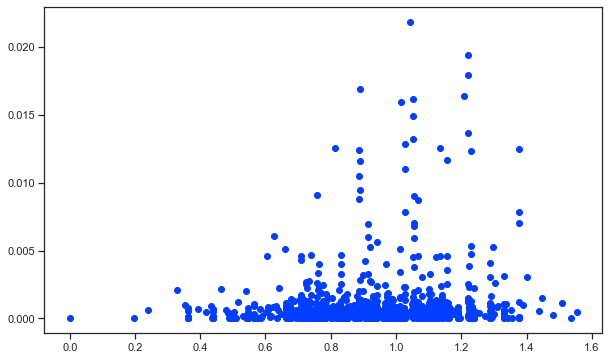

In [25]:
plt.scatter(beta_powers, pac_powers)

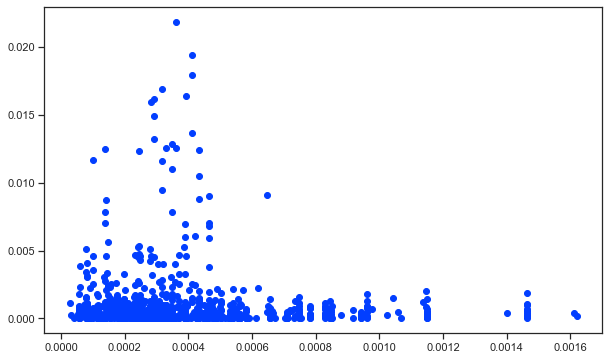

In [26]:
plt.scatter(hfo_powers, pac_powers)

In [28]:
for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho, pval = stats.pearsonr(beta_powers, pac_powers)
    if corr_type == 'spearman':
        rho, pval = stats.spearmanr(beta_powers, pac_powers)
    print(f"Beta-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval})")

Beta-PAC pearson correlation is 0.15 (p-value = 5.043492412451631e-06)
Beta-PAC spearman correlation is 0.15 (p-value = 2.850397440839932e-06)


In [30]:
for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho, pval = stats.pearsonr(hfo_powers, pac_powers)
    if corr_type == 'spearman':
        rho, pval = stats.spearmanr(hfo_powers, pac_powers)
    print(f"HFO-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval})")

HFO-PAC pearson correlation is -0.06 (p-value = 0.07415205793874007)
HFO-PAC spearman correlation is -0.08 (p-value = 0.015036791323365214)


### Computing correlations for all patients

In [5]:
p1 = load_patient(1)
p2 = load_patient(2)
p5 = load_patient(5)
p6 = load_patient(6)

Patient directory:  D:\LAB\AlexPAC\data\Patient1
Patient directory:  D:\LAB\AlexPAC\data\Patient2
Patient directory:  D:\LAB\AlexPAC\data\Patient5
Patient directory:  D:\LAB\AlexPAC\data\Patient6


In [6]:
p3 = load_patient(3, load_pac=False)
p3 = copy_patient(p3)
p3.save()
p3.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient3
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)
Saving Patient3 object to D:\LAB\AlexPAC\data\Patient3\Patient3.pkl ...
Pickling Patient3 without ['pac']
Done, 3.6950788497924805 sec
File size: 3449.7617979049683 MB
Returning filepath for saved file


In [25]:
total_pac_powers = []
total_beta_powers = []
total_hfo_powers = []

for patient in [p1, p2, p3, p5, p6]:
    
    pac_powers = []
    beta_powers = []
    hfo_powers = []

    conditions = [c for c in patient.conditions if ' 180sec' in c]

    for condition in tqdm(conditions, total=len(conditions)):
        for pp in patient.placements:
            # get spectral powers
            lfp = patient.lfp[condition][pp]
            beta_power = get_beta_power(lfp, freqs=(14, 35))
            for aa in patient.placements:
                
                if not pac_exists(patient, condition, pp, aa):
                    continue
                    
                lfp = patient.lfp[condition][aa]   
                hfo_power = get_hfo_power(lfp)

                # Get PAC power
                pac = patient.pac[condition][pp][aa]

                ## getting only significant PAC + leaving only "clustered" entries
                sig_pac = get_sig_pac(pac, significance=0.01, mask_lonely=True)

                ## adjusting for different matrix shapes of cross-PACs
                if pp != aa:
                    pac_power = compute_matrix_norm(sig_pac)
                else:
                    beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
                    beta35 = np.argmin(np.abs(pac.beta_freqs - 35))
                    hfo140 = np.argmin(np.abs(pac.hfo_freqs - 160))
                    pac_power = compute_matrix_norm(sig_pac[hfo140:, beta10:beta35 + 1])

                beta_powers.append(beta_power)
                hfo_powers.append(hfo_power)
                pac_powers.append(pac_power)
    total_pac_powers += pac_powers
    total_beta_powers += beta_powers
    total_hfo_powers += hfo_powers

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [34]:
for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho_pearson, pval_pearson = stats.pearsonr(total_beta_powers, total_pac_powers)
    if corr_type == 'spearman':
        rho_spearman, pval_spearman = stats.spearmanr(total_beta_powers, total_pac_powers)
    print(f"Beta-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval:.1e})")

Beta-PAC pearson correlation is 0.30 (p-value = 1.1e-91)
Beta-PAC spearman correlation is 0.31 (p-value = 5.4e-97)


In [35]:
for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho_pearson, pval_pearson = stats.pearsonr(total_hfo_powers, total_pac_powers)
    if corr_type == 'spearman':
        rho_spearman, pval_spearmanl = stats.spearmanr(total_hfo_powers, total_pac_powers)
    print(f"HFO-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval:.4f})")

HFO-PAC pearson correlation is 0.12 (p-value = 0.0000)
HFO-PAC spearman correlation is 0.06 (p-value = 0.0001)


## Beta-PAC correlation

In [4]:
df = pd.read_csv('beta_hfo_pac_powers_REST.csv', header=0, index_col=0)
df.head()

,patient,condition,phase,amplitude,beta_power,hfo_power,pac_power_p2,pac_power_p09,is_cross_pac,ldopa
0,Patient1,1Day ON Rest 180sec,R1-2A,R1-2A,0.471097,0.001178,0.0,0.0,0,ON
1,Patient1,1Day ON Rest 180sec,R1-2A,R4-3B,0.471097,0.001514,0.0,0.0,1,ON
2,Patient1,1Day ON Rest 180sec,R1-2A,R1-2B,0.471097,0.000648,0.0,0.0,1,ON
3,Patient1,1Day ON Rest 180sec,R1-2A,R4-3C,0.471097,0.001486,0.0,0.0,1,ON
4,Patient1,1Day ON Rest 180sec,R1-2A,R2B-3B,0.471097,0.000949,0.0,0.0,1,ON


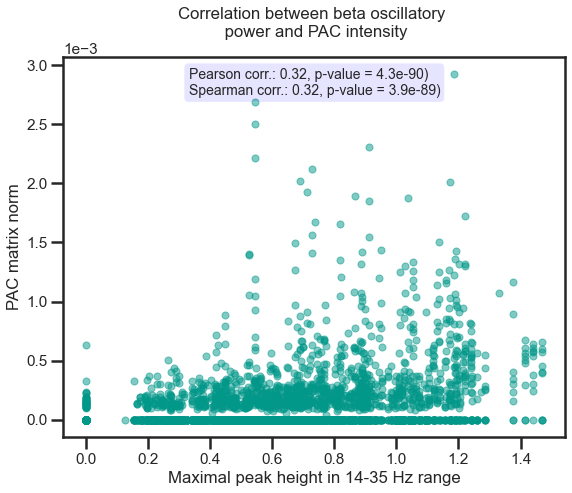

In [42]:
sns.set_context('poster', font_scale=0.7)


x = df['beta_power']
y = df['pac_power_p2']

for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho_pearson, pval_pearson = stats.pearsonr(x, y)
    if corr_type == 'spearman':
        rho_spearman, pval_spearman = stats.spearmanr(x, y)
    #print(f"Beta-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval:.1e})")

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.scatter(x, y, alpha=0.5, s=50, linewidths=1, color="#019789")
ax.set_title(f"Correlation between beta oscillatory \n power and PAC intensity", pad=20)
ax.set_xlabel("Maximal peak height in 14-35 Hz range")
ax.set_ylabel("PAC matrix norm")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

stat_result = f"Pearson corr.: {rho_pearson:.2f}, p-value = {pval_pearson:.1e}) \nSpearman corr.: {rho_spearman:.2f}, p-value = {pval_spearman:.1e})"
ax.text(0.25, 0.9, 
        s=stat_result, 
        bbox=dict(boxstyle="round", facecolor='blue', alpha=0.1), transform=ax.transAxes, fontsize=14)

with open("path_data.txt", 'r') as f:
        data_path = f.readline()
    
plt.savefig(os.path.join(data_path, 'im_common', f'Beta-PAC-corr.png'), dpi=200, bbox_inches='tight')

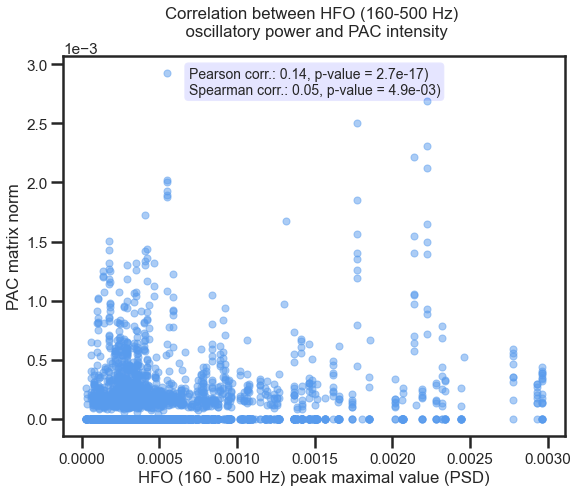

In [43]:
sns.set_context('poster', font_scale=0.7)


x = df['hfo_power']
y = df['pac_power_p2']

rho_pearson, pval_pearson = stats.pearsonr(x, y)
rho_spearman, pval_spearman = stats.spearmanr(x, y)

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.scatter(x, y, alpha=0.5, s=50, linewidths=1, color='#589bed')
ax.set_title(f"Correlation between HFO (160-500 Hz) \n oscillatory power and PAC intensity", pad=20)
plt.xlabel("HFO (160 - 500 Hz) peak maximal value (PSD)")
ax.set_ylabel("PAC matrix norm")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

stat_result = f"Pearson corr.: {rho_pearson:.2f}, p-value = {pval_pearson:.1e}) \nSpearman corr.: {rho_spearman:.2f}, p-value = {pval_spearman:.1e})"
ax.text(0.25, 0.9, 
        s=stat_result, 
        bbox=dict(boxstyle="round", facecolor='blue', alpha=0.1), transform=ax.transAxes, fontsize=14)

with open("path_data.txt", 'r') as f:
        data_path = f.readline()
    
plt.savefig(os.path.join(data_path, 'im_common', f'HFO-PAC-corr.png'), dpi=200, bbox_inches='tight')

In [47]:
print(len(total_hfo_powers))

4228


In [40]:
total_pac_powers = np.array(total_pac_powers)
total_beta_powers = np.array(total_beta_powers)
total_hfo_powers = np.array(total_hfo_powers)

Hfo-PAC pearson correlation is 0.00 (p-value = 0.8654890292177622)
Hfo-PAC spearman correlation is 0.02 (p-value = 0.19128276943405068)


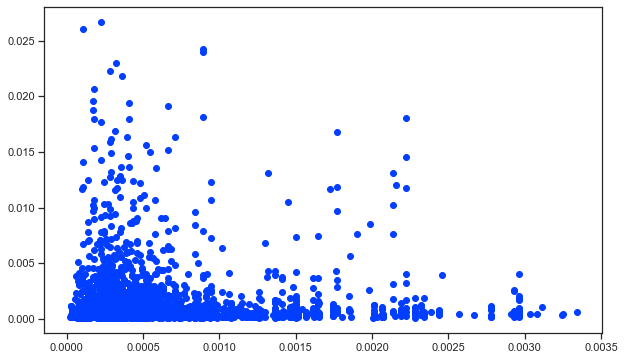

In [46]:
for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho, pval = stats.pearsonr(total_hfo_powers[mask], total_pac_powers[mask])
    if corr_type == 'spearman':
        rho, pval = stats.spearmanr(total_hfo_powers[mask], total_pac_powers[mask])
    print(f"Hfo-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval:.4f})")
    
plt.scatter(total_hfo_powers[mask], total_pac_powers[mask])

### Training a linear model on two variables

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def mse(y_hat, y_true):
    return np.mean((y_hat - y_true) ** 2)

In [74]:
model = LinearRegression()

X = np.vstack((total_beta_powers, total_hfo_powers)).T
y = total_pac_powers

print(X.shape)

model.fit(X, y)
print()
print(f"Total error: {mse(X @ model.coef_, y):.1e}")
print(f"Mean y value: {y.mean():.1e}")
print(f"Max y value: {y.max():.1e}")
print(f"Coefficients: Beta - {model.coef_[0]:.4f}, HFO - {model.coef_[1]:.4f}")

(4228, 2)

Total error: 5.3e-06
Mean y value: 9.6e-04
Max y value: 2.7e-02
Coefficients: Beta - 0.0015, HFO - 0.2351


In [79]:
X_train[0]

array([0.83954505, 0.00089211])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print(f"Test error: {mse(model.predict(X_test), y_test):.1e}")
print(f"Test error: {mse(model.predict(X_train), y_train):.1e}")

Test error: 5.6e-06
Test error: 4.8e-06


But coefficients are nothing if we do not normalize them. So let us normalize our features to have zero mean and unit variance

In [83]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [88]:
model.fit(X_train_scaled, y_train_scaled.reshape(-1))
model.coef_

array([0.07804351, 0.01735653])

In [91]:
print(f"Test error: {mse(model.predict(X_test_scaled), y_test_scaled):.3f}")
print(f"Train error: {mse(model.predict(X_train_scaled), y_train_scaled):.3f}")

print(f"Mean y value: {y_train_scaled.mean():.3f}")
print(f"Max y value: {y_train_scaled.max():.3f}")
print(f"Coefficients: Beta - {model.coef_[0]:.3f}, HFO - {model.coef_[1]:.3f}")

Test error: 0.008
Train error: 0.007
Mean y value: 0.036
Max y value: 1.000
Coefficients: Beta - 0.078, HFO - 0.017


### IDEA: let us try to predict bipartate graph purely from spectral data and compare it to real cross-PAC measurements

Basically cross-validation: train on 4 patients, predict one. Maybe even one of the two conditions: OFF or ON. Maybe predict ON based on OFF or vice versa. 

The ultimate result should be reconstructed bipartate graph with correct predicted edge weights as well as edges themselves.

#### 1. Get Beta and HFO power estimates for all patients (X_train) and leave one out (X_test)

In [95]:
import networkx as nx

def get_bigraph(patient, 
                condition, 
                signficance=0.01, 
                norm_type='p', 
                p=0.9, 
                norm_threshold=2e-3, 
                cross_placements=None):
    """
    Computes adjacency matrix for a given patient and condition
    - Significant (p = significance (default=0.01))
    - With 0-valued non-clustered PAC values (no non-zero significant neighbours) (See mask_nonclustered function)
    - Using matrix p-norm
    - For cross-PACs the whole matrix is take, for the inter-PACs only the corresponding part (10-35, 160-500)
    Returns networkx directed Graph object. Phase-giving placements are marked as "-p" and amplitude as "-a"
    """
    
    # 1. Initialize placements for bi-graph (default: None)
    if cross_placements is None:
        cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                            "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]
        
    n = len(cross_placements)
    adjacency_matrix = np.zeros(shape=(n, n))
    
    # 2. Compute adjacency matrix
    for i in range(n):
        for j in range(n):
            phase = cross_placements[i]
            amplitude = cross_placements[j]
            if not pac_exists(patient, condition, phase, amplitude):
                    continue
            if not pac_exists(patient, condition, phase, amplitude):
                    continue
            pac = patient.pac[condition][phase][amplitude]
            
            # getting only significant PAC + leaving only "clustered" entries
            sig_pac = get_sig_pac(pac, significance=0.01, mask_lonely=True)
            norm = compute_matrix_norm(sig_pac, norm=norm_type, p=p)
            
            if phase != amplitude:
                norm = compute_matrix_norm(sig_pac, norm=norm_type, p=p)
            else:
                beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
                beta35 = np.argmin(np.abs(pac.beta_freqs - 35))
                hfo140 = np.argmin(np.abs(pac.hfo_freqs - 140))
                norm = compute_matrix_norm(sig_pac[hfo140:, beta10:beta35 + 1], norm=norm_type, p=p)
            if norm > norm_threshold:
                adjacency_matrix[i, j] = np.round(norm * 1e3, 2)
    
    # 3. Initialize graph and nodes
    G = nx.DiGraph()

    nodes_left = [node + '-p' for node in cross_placements]
    nodes_right = [node + '-a' for node in cross_placements]
    
    
    G.add_nodes_from(nodes_left, bipartite=0)
    G.add_nodes_from(nodes_right, bipartite=1)
    
    # 4. Add edges from adjacency matrix
    for i in range(n):
        for j in range(n):
            weight = adjacency_matrix[i, j]
            if weight != 0:
                G.add_edge(nodes_left[i], nodes_right[j], weight=weight)
                
    return G



def draw_bigraph(G, ax, colors=None):
    cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                        "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]
    n = len(cross_placements)
    # get node names
    nodes_left = [node + '-p' for node in cross_placements]
    nodes_right = [node + '-a' for node in cross_placements]
    
    # get node positions
    y2 = np.array([0.1, 0.18, 0.26, 0.42, 0.5, 0.58, 0.74, 0.82, 0.9])[::-1]
    y1 = -y2[::-1]
    pos_y = np.concatenate((y1, y2)).reshape(-1, 1)
    #pos_y = np.concatenate((- np.linspace(-0.85, -0.1, n // 2), - np.linspace(0.1, 0.85, n // 2))).reshape(-1, 1)
    pos_left = np.hstack((-0.5 * np.ones((n, 1)), pos_y))
    pos_right = np.hstack((0.5 * np.ones((n, 1)), pos_y)) 

    positions_left = {node:position for node, position in zip(nodes_left, pos_left)}
    positions_right = {node:position for node, position in zip(nodes_right, pos_right)}

    pos = {**positions_left, **positions_right}
    
    weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
    
    if colors is None:
        aquamarine = np.array([127, 125, 212]) / 256
        goldenrod = np.array([255, 193, 37]) / 256
        colors = (aquamarine, goldenrod)
        node_color = [colors[0] for _ in range(n)] + [colors[1] for _ in range(n)]
        
    else:
        node_color=colors

    nx.draw_networkx(G, 
                     ax=ax,
                     pos=pos, 
                     arrows=True, 
                     arrowstyle='->', 
                     width=weights / 8, 
                     node_size=500, 
                     node_color=node_color, alpha=0.8)
    
    ax.margins(0.1, 0)

Было бы круто параллельно с массивом данных сделать массив принадлежности этих данных пациентам, e.g.:

x_1, x_2, x_3, ..., x_l

p1d1off

Можно сделать pandas dataframe, это будет удобно

## Pandas dataframe

In [ ]:
# loading patients

In [2]:
# patient 3 - test
#
p1 = load_patient(1)
p2 = load_patient(2)
p3 = load_patient(3)
p4 = load_patient(4)
p5 = load_patient(5)
p6 = load_patient(6)

Patient directory:  D:\LAB\AlexPAC\data\Patient1
Patient directory:  D:\LAB\AlexPAC\data\Patient2
Patient directory:  D:\LAB\AlexPAC\data\Patient3
Patient directory:  D:\LAB\AlexPAC\data\Patient4
Patient directory:  D:\LAB\AlexPAC\data\Patient5
Patient directory:  D:\LAB\AlexPAC\data\Patient6


In [7]:
cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                            "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]

for patient in [p1, p2, p3, p4, p5, p6]:
    patient.cross_placements = cross_placements
    patient.save()

Saving Patient1 object to D:\LAB\AlexPAC\data\Patient1\Patient1.pkl ...
Pickling Patient1 without ['pac']
Done, 22.91841459274292 sec
File size: 2788.2313117980957 MB
Returning filepath for saved file
Saving Patient2 object to D:\LAB\AlexPAC\data\Patient2\Patient2.pkl ...
Pickling Patient2 without ['pac']
Done, 14.574212074279785 sec
File size: 1852.8679914474487 MB
Returning filepath for saved file
Saving Patient3 object to D:\LAB\AlexPAC\data\Patient3\Patient3.pkl ...
Pickling Patient3 without ['pac']
Done, 27.74341058731079 sec
File size: 3449.764186859131 MB
Returning filepath for saved file
Saving Patient4 object to D:\LAB\AlexPAC\data\Patient4\Patient4.pkl ...
Pickling Patient4 without ['pac']
Done, 4.77709436416626 sec
File size: 2330.3172283172607 MB
Returning filepath for saved file
Saving Patient5 object to D:\LAB\AlexPAC\data\Patient5\Patient5.pkl ...
Pickling Patient5 without ['pac']
Done, 21.401559591293335 sec
File size: 3022.928337097168 MB
Returning filepath for saved f

In [5]:
total_pac_powers = []
total_beta_powers = []
total_hfo_powers = []

columns = ['patient', 'condition', 'phase', 'amplitude', 'beta_power', 'hfo_power', 'pac_power_p2', 'pac_power_p09', 'is_cross_pac']
data = pd.DataFrame(columns=columns)

for patient in [p1, p2, p3, p4, p5, p6]:
    pac_powers = []
    beta_powers = []
    hfo_powers = []
    
    conditions = [c for c in patient.conditions if 'Rest 180sec' in c]
    for condition in tqdm(conditions, total=len(conditions)):
        day, ldopa, movement = retrieve_condition_name(condition)
        for pp in patient.placements:
            # get spectral powers
            lfp = patient.lfp[condition][pp]
            beta_power = get_beta_power(lfp)

            for pa in patient.placements:
                if not pac_exists(patient, condition, pp, pa):
                    continue
                    
                lfp = patient.lfp[condition][pa]
                hfo_power = get_hfo_power(lfp)

                # Get PAC power
                pac = patient.pac[condition][pp][pa]

                ## getting only significant PAC + leaving only "clustered" entries
                sig_pac = get_sig_pac(pac, significance=0.01, mask_lonely=True)

                ## adjusting for different matrix shapes of cross-PACs
                if pp != pa:
                    pac_power_p2 = compute_matrix_norm(sig_pac, p=2)
                    pac_power_p09 = compute_matrix_norm(sig_pac, p=0.9)
                else:
                    beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
                    beta35 = np.argmin(np.abs(pac.beta_freqs - 35))
                    hfo140 = np.argmin(np.abs(pac.hfo_freqs - 160))
                    pac_power_p2 = compute_matrix_norm(sig_pac[hfo140:, beta10:beta35 + 1], p=2)
                    pac_power_p09 = compute_matrix_norm(sig_pac[hfo140:, beta10:beta35 + 1], p=0.9)
                
                df = {'patient': patient.name, 
                      'condition': condition,
                      'phase': pp, 
                      'amplitude': pa, 
                      'beta_power': beta_power, 
                      'hfo_power': hfo_power, 
                      'pac_power_p2': pac_power_p2, 
                      'pac_power_p09': pac_power_p09,
                      'is_cross_pac': int(pp != pa)
                     }

                data = data.append(df, ignore_index = True)

#                 beta_powers.append(beta_power)
#                 hfo_powers.append(hfo_power)
#                 pac_powers.append(pac_power)
#     total_pac_powers += pac_powers
#     total_beta_powers += beta_powers
#     total_hfo_powers += hfo_powers
    
data.to_csv('beta_hfo_pac_powers_REST.csv', sep=',')

  0%|          | 0/4 [00:00<?, ?it/s]

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [168]:
retrieve_condition_name("1Day OFF Rest 180sec")

('1Day', 'OFF', 'Rest 180sec')

In [170]:
cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                    "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]

data['cross_pac'] = data.apply(lambda d: int((d.pp in cross_placements) and (d.pa in cross_placements)), axis=1)
data.to_csv('beta_pac_power.csv', sep=',')

In [171]:
data.head(10)

,patient,day,ldopa,movement,pp,pa,beta_power,hfo_power,pac_power,cross_pac
0,Patient1,5Day,OFF,Rest 180sec,L3B-3A,L3B-3A,1.102881,0.000244,0.007223,0
1,Patient1,5Day,OFF,Rest 180sec,R4-3B,R4-3B,1.440566,0.000217,0.017411,1
2,Patient1,5Day,OFF,Rest 180sec,R4-3B,R2C-3C,1.440566,0.000294,0.003333,1
3,Patient1,5Day,OFF,Rest 180sec,R4-3B,R2A-3A,1.440566,0.000359,0.002868,1
4,Patient1,5Day,OFF,Rest 180sec,R4-3B,R1-2B,1.440566,0.000255,0.000110,1
5,Patient1,5Day,OFF,Rest 180sec,R4-3B,R1-2A,1.440566,0.000297,0.000461,1
6,Patient1,5Day,OFF,Rest 180sec,R4-3B,R4-3A,1.440566,0.000270,0.007067,1
7,Patient1,5Day,OFF,Rest 180sec,R4-3B,R1-2C,1.440566,0.000259,0.001862,1
8,Patient1,5Day,OFF,Rest 180sec,R4-3B,R2B-3B,1.440566,0.000358,0.003302,1
9,Patient1,5Day,OFF,Rest 180sec,R4-3B,R4-3C,1.440566,0.000259,0.002717,1


In [172]:
data.corr(method='spearman')

,beta_power,hfo_power,pac_power,cross_pac
beta_power,1.000000,-0.251442,0.095821,0.094379
hfo_power,-0.251442,1.000000,-0.036202,0.072480
pac_power,0.095821,-0.036202,1.000000,-0.215475
cross_pac,0.094379,0.072480,-0.215475,1.000000


In [173]:
X = np.array(data[['beta_power', 'hfo_power']])
y = np.array(data['pac_power'])

model = LinearRegression().fit(X, y)

print(mse(model.predict(X), y))
print(y.mean())
print(y.max())
print(model.coef_)

6.55276419339762e-05
0.0022496250355711796
0.15646123451722224
[ 0.0022541  -0.64201678]


#### Training model on all patients except one

In [174]:
X_train = np.array(data[data.patient != 'Patient3'][['beta_power', 'hfo_power']])
y_train = np.array(data[data.patient != 'Patient3']['pac_power'])

X_test = np.array(data[data.patient == 'Patient3'][['beta_power', 'hfo_power']])
y_test = np.array(data[data.patient == 'Patient3']['pac_power'])

In [175]:
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [176]:
data_p3 = data[data.patient == 'Patient3']

In [177]:
data_p3['pac_power_pred'] = y_hat

C:\Users\aleks\AppData\Local\Temp/ipykernel_19696/445457184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p3['pac_power_pred'] = y_hat


In [185]:
data_test = data_p3[data_p3.day == '5Day'][data_p3.ldopa == 'OFF'][data_p3.movement == 'Rest 180sec']

C:\Users\aleks\AppData\Local\Temp/ipykernel_19696/1703490281.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_test = data_p3[data_p3.day == '5Day'][data_p3.ldopa == 'OFF'][data_p3.movement == 'Rest 180sec']


In [186]:
data_test.head()

,patient,day,ldopa,movement,pp,pa,beta_power,hfo_power,pac_power,cross_pac,pac_power_pred
1779,Patient3,5Day,OFF,Rest 180sec,L3B-3A,L3B-3A,1.336798,0.000076,0.001231,0,0.003238
1780,Patient3,5Day,OFF,Rest 180sec,R4-3B,R4-3B,1.228421,0.000245,0.007950,1,0.002864
1781,Patient3,5Day,OFF,Rest 180sec,R4-3B,R2C-3C,1.228421,0.000119,0.000146,1,0.002873
1782,Patient3,5Day,OFF,Rest 180sec,R4-3B,R2A-3A,1.228421,0.000116,0.000453,1,0.002873
1783,Patient3,5Day,OFF,Rest 180sec,R4-3B,R1-2B,1.228421,0.000080,0.000279,1,0.002876


<AxesSubplot:>

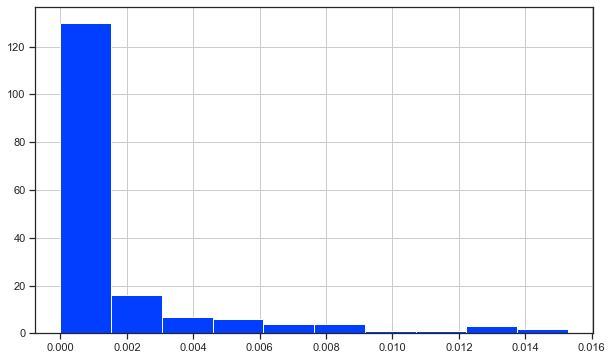

In [214]:
data_test.pac_power.hist()

<AxesSubplot:>

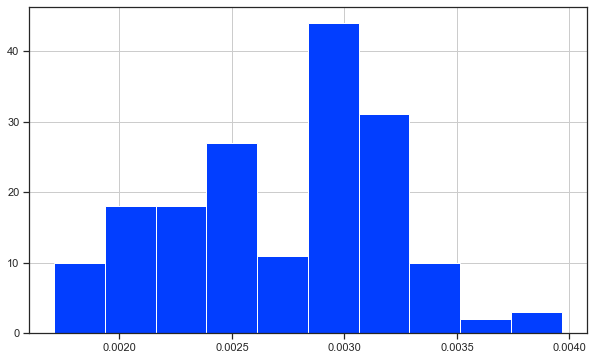

In [213]:
data_test.pac_power_pred.hist()

In [210]:
cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                    "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]

n = len(cross_placements)

G = nx.DiGraph()

nodes_left = [node + '-p' for node in cross_placements]
nodes_right = [node + '-a' for node in cross_placements]


G.add_nodes_from(nodes_left, bipartite=0)
G.add_nodes_from(nodes_right, bipartite=1)

# 4. Add edges from adjacency matrix
for i in range(n):
    pp = cross_placements[i]
    for j in range(n):
        pa = cross_placements[j]
        val = data_test[data_test.pp == pp][data_test.pa == pa]['pac_power_pred'].values
        if len(val) == 0:
            weight = 0
        else:
            weight = val[0] * 1e3
        if weight != 0:
            G.add_edge(nodes_left[i], nodes_right[j], weight=weight)
                

C:\Users\aleks\AppData\Local\Temp/ipykernel_19696/2871938757.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val = data_test[data_test.pp == pp][data_test.pa == pa]['pac_power_pred'].values


In [211]:
for i in range(n):
    pp = cross_placements[i]
    for j in range(n):
        pa = cross_placements[j]
        val = data_test[data_test.pp == pp][data_test.pa == pa]['pac_power_pred'].values
        if len(val) == 0:
            weight = 0
        else:
            weight = val[0] * 1e3
        #print(f"{pp} -> {pa}: {weight}")

C:\Users\aleks\AppData\Local\Temp/ipykernel_19696/1375488429.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val = data_test[data_test.pp == pp][data_test.pa == pa]['pac_power_pred'].values


In [204]:
pp = 'L1-2A'
pa = 'R1-2A'

data_test[data_test.pp == pp][data_test.pa == pa]

C:\Users\aleks\AppData\Local\Temp/ipykernel_19696/3995294354.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_test[data_test.pp == pp][data_test.pa == pa]


,patient,day,ldopa,movement,pp,pa,beta_power,hfo_power,pac_power,cross_pac,pac_power_pred


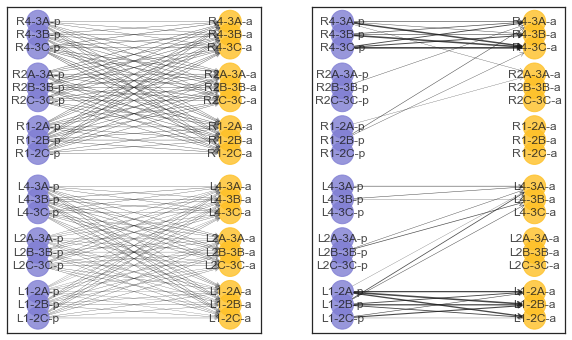

In [212]:
fig, axes = plt.subplots(1, 2, sharey=True)

draw_bigraph(G, axes[0], colors=None)

G_true = get_bigraph(p3, "5Day OFF Rest 180sec")

draw_bigraph(G_true, axes[1])

In [193]:
a = data_test[data_test.pp == 'L1-2A'][data_test.pa == 'L2A-3A']['pac_power_pred']

C:\Users\aleks\AppData\Local\Temp/ipykernel_19696/3514719268.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = data_test[data_test.pp == 'L1-2A'][data_test.pa == 'L2A-3A']['pac_power_pred']


In [195]:
a.values

array([0.00172909])

## Computing correlations

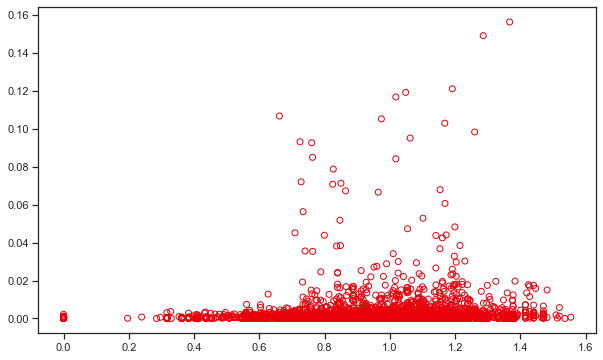

In [220]:
plt.scatter(data.beta_power, data.pac_power, facecolors='none', edgecolors='r')

In [221]:
for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho, pval = stats.pearsonr(data.beta_power, data.pac_power)
    if corr_type == 'spearman':
        rho, pval = stats.spearmanr(data.beta_power, data.pac_power)
    print(f"Beta-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval:.1e})")

Beta-PAC pearson correlation is 0.07 (p-value = 3.6e-06)
Beta-PAC spearman correlation is 0.10 (p-value = 4.3e-10)


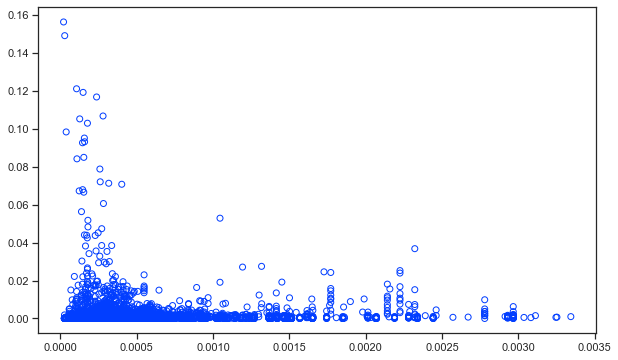

In [222]:
plt.scatter(data.hfo_power, data.pac_power, facecolors='none', edgecolors='b')

In [223]:
for corr_type in ["pearson", "spearman"]:
    if corr_type == 'pearson':
        rho, pval = stats.pearsonr(data.hfo_power, data.pac_power)
    if corr_type == 'spearman':
        rho, pval = stats.spearmanr(data.hfo_power, data.pac_power)
    print(f"HFO-PAC {corr_type} correlation is {rho:.2f} (p-value = {pval:.4f})")

HFO-PAC pearson correlation is -0.05 (p-value = 0.0010)
HFO-PAC spearman correlation is -0.04 (p-value = 0.0186)
